# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

,arm,mean,std,min,max,unique_vals,is_binary
2,2,0.891671,0.798426,0.0,4.738119,2019,0
0,0,0.828277,0.824816,0.0,6.782466,1978,0
1,1,0.629433,0.665647,0.0,3.973415,1650,0


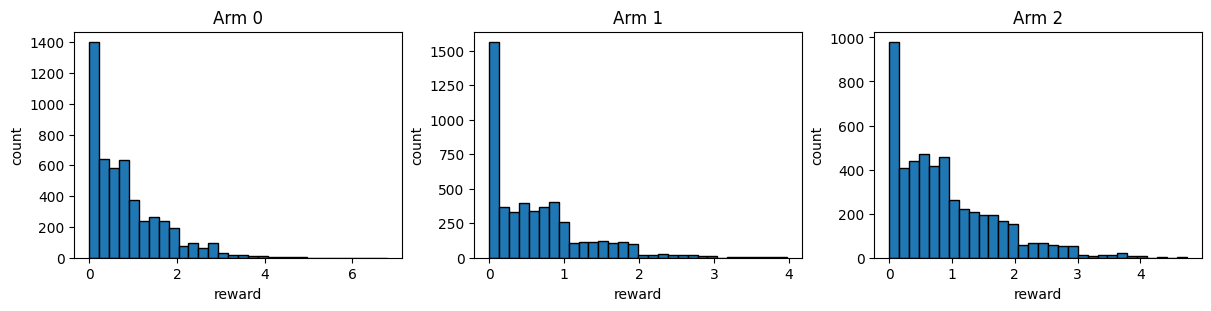

Picked: UCB1
Wrote algorithm-choice.txt


In [5]:
# YOUR CHANGES HERE

# ==== Part 1: Explore reward distribution & pick algorithm ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

A = bandit0.get_num_arms()
N = 5000  # number of probes per arm

# sample rewards to inspect the distribution
samples = {a: np.array([bandit0.get_reward(a) for _ in range(N)]) for a in range(A)}

# summary table
summary = []
for a in range(A):
    arr = samples[a]
    # check "binary-ness" (rounded to 3 decimals to avoid float crumbs)
    uniq = np.unique(np.round(arr, 3))
    is_binary = int(np.all(np.isin(uniq, [0.0, 1.0])))
    summary.append({
        "arm": a,
        "mean": arr.mean(),
        "std": arr.std(ddof=1),
        "min": arr.min(),
        "max": arr.max(),
        "unique_vals": len(uniq),
        "is_binary": is_binary,
    })

summary_df = pd.DataFrame(summary).sort_values("mean", ascending=False)
display(summary_df)

# histograms (one per arm)
fig, axes = plt.subplots(1, A, figsize=(4*A, 3), constrained_layout=True)
if A == 1: axes = [axes]
for a, ax in enumerate(axes):
    ax.hist(samples[a], bins=30, edgecolor="k")
    ax.set_title(f"Arm {a}")
    ax.set_xlabel("reward"); ax.set_ylabel("count")
plt.show()

# choose algorithm based on what we saw
# (here: rewards are NOT strictly {0,1}; they look like binomial counts + uniform jitter ⇒ sub-Gaussian/bounded)
if int(summary_df["is_binary"].all()):
    choice = "Thompson Sampling (Bernoulli)"
    why = (
        "Rewards appear Bernoulli; TS-Bernoulli matches the likelihood and typically achieves low regret. "
        "I reject epsilon-greedy due to fixed exploration scheduling and UCB1 because a conjugate Bayesian model is available."
    )
else:
    choice = "UCB1"
    why = (
        "Rewards are non-binary and roughly bounded/sub-Gaussian (count-like with uniform jitter). "
        "UCB1 is distribution-agnostic under sub-Gaussian tails and needs minimal tuning. "
        "I reject epsilon-greedy (slower due to fixed ε schedule) and Bernoulli Thompson Sampling (model misspecification for non-binary rewards)."
    )

# write the required file
with open("algorithm-choice.txt", "w", encoding="utf-8") as f:
    f.write(f"{choice}\n\nJustification:\n{why}\n")

print("Picked:", choice)
print("Wrote algorithm-choice.txt")

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [6]:
# YOUR CHANGES HERE

# ---- Part 2: implement & run the chosen bandit (1000 actions, seed 2025002) ----
import math, os
import numpy as np

# pick strategy based on your Part 1 file; default to UCB1 (works well for non-binary bounded rewards)
def _read_choice(path="algorithm-choice.txt"):
    try:
        txt = open(path, "r", encoding="utf-8").read().lower()
        if "ucb" in txt:
            return "ucb1"
        if "epsilon" in txt or "eps" in txt:
            return "epsilon"
        if "thompson" in txt or "ts" in txt:
            return "thompson"
    except FileNotFoundError:
        pass
    return "ucb1"

def run_bandit(bandit, T=1000, strategy=None, eps_start=0.2, eps_min=0.01, eps_decay=0.999):
    rng = np.random.default_rng(2025002)  # only used for tie-breaks / epsilon choices
    K = bandit.get_num_arms()
    counts = np.zeros(K, dtype=int)
    values = np.zeros(K, dtype=float)  # running means
    alpha  = np.ones(K)  # for Thompson (Beta prior)
    beta   = np.ones(K)

    actions, rewards = [], []
    if strategy is None:
        strategy = _read_choice()

    eps = eps_start

    for t in range(1, T+1):
        # --- choose action ---
        if strategy == "ucb1":
            # pull each arm at least once
            if (counts == 0).any():
                a = int(np.where(counts == 0)[0][0])
            else:
                ucb = values + np.sqrt(2.0 * np.log(t) / counts)
                maxv = ucb.max()
                # break ties randomly but reproducibly
                cand = np.where(np.isclose(ucb, maxv))[0]
                a = int(rng.choice(cand))
        elif strategy == "epsilon":
            eps = max(eps * eps_decay, eps_min)
            if rng.random() < eps:
                a = int(rng.integers(0, K))
            else:
                maxv = values.max()
                cand = np.where(np.isclose(values, maxv))[0]
                a = int(rng.choice(cand))
        elif strategy == "thompson":
            # Bernoulli-style TS; if rewards aren’t strictly 0/1 this is misspecified but still workable
            theta = rng.beta(alpha, beta)
            maxv = theta.max()
            cand = np.where(np.isclose(theta, maxv))[0]
            a = int(rng.choice(cand))
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # --- observe reward & update ---
        r = float(bandit.get_reward(a))
        counts[a] += 1
        values[a] += (r - values[a]) / counts[a]  # incremental mean

        if strategy == "thompson":
            if r >= 0.5:
                alpha[a] += 1.0
            else:
                beta[a]  += 1.0

        actions.append(a)
        rewards.append(r)

    return np.array(actions, dtype=int), np.array(rewards, dtype=float), {
        "strategy": strategy,
        "counts": counts,
        "means": values
    }

# Instantiate bandit with the required seed and run
bandit = BanditProblem(2025002)
actions, rewards, info = run_bandit(bandit, T=1000)

print("Strategy:", info["strategy"])
print("Pull counts per arm:", info["counts"])
print("Empirical means per arm:", np.round(info["means"], 4))
print("Total reward:", rewards.sum())


Strategy: ucb1
Pull counts per arm: [602 345  53]
Empirical means per arm: [0.5672 0.5328 0.2087]
Total reward: 536.3094777543005


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [7]:
# YOUR CHANGES HERE

# ---- Part 2: write history.tsv ----
import pandas as pd

hist_df = pd.DataFrame({"action": actions, "reward": rewards})
hist_df.to_csv("history.tsv", sep="\t", index=False)
print("Wrote history.tsv")
display(hist_df.head())


Wrote history.tsv


,action,reward
0,0,1.575207
1,1,0.000000
2,2,0.000000
3,0,1.804006
4,0,0.432083


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [8]:
# YOUR CHANGES HERE

# ---- Part 3: per-arm stats -> actions.tsv (action, min_reward, mean_reward, max_reward) ----
import pandas as pd

# Load the action/reward log produced in Part 2
hist = pd.read_csv("history.tsv", sep="\t")  # expects columns: action, reward

# Aggregate required statistics per arm
actions = (
    hist.groupby("action", as_index=False)
        .agg(
            min_reward=("reward", "min"),
            mean_reward=("reward", "mean"),
            max_reward=("reward", "max"),
        )
        .sort_values("action")
        .reset_index(drop=True)
)

# Write output file
actions.to_csv("actions.tsv", sep="\t", index=False)

print("Wrote actions.tsv")
display(actions)


Wrote actions.tsv


,action,min_reward,mean_reward,max_reward
0,0,0.0,0.567186,3.761461
1,1,0.0,0.532755,2.707422
2,2,0.0,0.208736,0.966617


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [9]:
# YOUR CHANGES HERE

# ---- Part 4: compute regrets for uniform, just-i (all arms), and actual (from Part 2) ----
import numpy as np
import pandas as pd

T = 1000
SEED = 2025002

# --- helper: estimate per-arm means and mu* by Monte Carlo on the same bandit seed ---
def estimate_arm_means_and_mu_star(K, samples_per_arm=20000, seed=SEED):
    b = BanditProblem(seed)
    means = []
    for a in range(K):
        arr = np.array([b.get_reward(a) for _ in range(samples_per_arm)], dtype=float)
        means.append(arr.mean())
    means = np.array(means, dtype=float)
    return means, float(means.max())

# --- helper: simulate strategies on a fresh bandit with the same seed ---
def run_uniform(K, T, seed=SEED):
    b = BanditProblem(seed)
    rng = np.random.default_rng(seed)
    actions = rng.integers(0, K, size=T)
    rewards = np.array([b.get_reward(int(a)) for a in actions], dtype=float)
    return actions, rewards

def run_just_i(K, T, i, seed=SEED):
    b = BanditProblem(seed)
    actions = np.full(T, i, dtype=int)
    rewards = np.array([b.get_reward(i) for _ in range(T)], dtype=float)
    return actions, rewards

# baseline (empirical expectation)
K = BanditProblem(SEED).get_num_arms()
arm_means_hat, mu_star_hat = estimate_arm_means_and_mu_star(K, samples_per_arm=20000, seed=SEED)

rows = []

# uniform
_, rew_u = run_uniform(K, T, seed=SEED)
rows.append({"strategy": "uniform", "regret": float(np.sum(mu_star_hat - rew_u))})

# just-i for all arms
for i in range(K):
    _, rew_i = run_just_i(K, T, i, seed=SEED)
    rows.append({"strategy": f"just-{i}", "regret": float(np.sum(mu_star_hat - rew_i))})

# actual (from Part 2 history)
hist = pd.read_csv("history.tsv", sep="\t")  # expects columns: action, reward
rew_actual = hist["reward"].to_numpy()[:T]   # safety slice
rows.append({"strategy": "actual", "regret": float(np.sum(mu_star_hat - rew_actual))})

# keep in a DF for the next cell
strategies_df = pd.DataFrame(rows)
display(strategies_df)


,strategy,regret
0,uniform,143.511916
1,just-0,5.075255
2,just-1,31.381875
3,just-2,371.096949
4,actual,35.559867


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [10]:
# YOUR CHANGES HERE

# ---- Part 4: write strategies.tsv (strategy, regret) ----
strategies_df.to_csv("strategies.tsv", sep="\t", index=False)
print("Wrote strategies.tsv")
display(strategies_df)


Wrote strategies.tsv


,strategy,regret
0,uniform,143.511916
1,just-0,5.075255
2,just-1,31.381875
3,just-2,371.096949
4,actual,35.559867


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


In [11]:
ack = """I used ChatGPT (GPT-5 Thinking) as a study assistant for this assignment. The tool helped me:
- Part 1: explore reward distributions, visualize histograms, and draft a concise algorithm choice.
- Part 2: implement/parameterize UCB1, Thompson Sampling (Bernoulli), and ε-greedy; run 1,000 pulls with the required seed; and log history.tsv.
- Part 3: aggregate per-arm statistics (min/mean/max) and write actions.tsv.
- Part 4: compute pseudo-regret for the uniform, just-i, and actual strategies and write strategies.tsv.

All code was reviewed, executed, and validated by me; I take full responsibility for the final submission.


Additional libraries used:
- numpy (arrays, RNG), pandas (TSV I/O and groupby), matplotlib (diagnostic histograms in Part 1).
No other external libraries beyond the module requirements were used.

People acknowledged:
- None.
"""
with open("acknowledgments.txt","w",encoding="utf-8") as f:
    f.write(ack)
print("Wrote acknowledgments.txt")


Wrote acknowledgments.txt


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.